**Chọn tập dữ liệu: MBA Admission**

Mô tả tập dữ liệu
1. Nguồn dữ liệu:
Dữ liệu tổng hợp được tạo từ số liệu thống kê của Lớp Wharton năm 2025.

2. Siêu dữ liệu:
 * application_id: Mã định danh duy nhất cho mỗi đơn đăng ký
 * gender: Giới tính của ứng viên (Nam, Nữ)
 * international: Sinh viên quốc tế (ĐÚNG/SAI)
 * gpa: Điểm trung bình tích lũy của ứng viên (trên thang điểm 4.0)
 * major: Chuyên ngành đại học (Kinh doanh, STEM, Khoa học nhân văn)
 * race: Xuất thân chủng tộc của ứng viên (ví dụ: Da trắng, Da đen, Châu Á, Người gốc Tây Ban Nha, Khác / null: sinh viên quốc tế)
 * gmat: Điểm GMAT của ứng viên (800 điểm)
 * work_exp: Số năm kinh nghiệm làm việc (Năm)
 * work_industry: Ngành nghề có kinh nghiệm làm việc trước đây của ứng viên (ví dụ: Tư vấn, Tài chính, Công nghệ, v.v.)
 * admission: Trạng thái tuyển sinh (Được nhận, Danh sách chờ, Null: Từ chối)

# Mô tả bài toán: dự đoán trạng thái nhập học

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

#for evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#models
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, silhouette_visualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Tải dữ liệu
df = pd.read_csv('/content/drive/MyDrive/MachineLearning/MBA Admission dataset/MBA.csv')

In [4]:
df.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


In [5]:
df.drop('application_id',axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         6194 non-null   object 
 1   international  6194 non-null   bool   
 2   gpa            6194 non-null   float64
 3   major          6194 non-null   object 
 4   race           4352 non-null   object 
 5   gmat           6194 non-null   float64
 6   work_exp       6194 non-null   float64
 7   work_industry  6194 non-null   object 
 8   admission      1000 non-null   object 
dtypes: bool(1), float64(3), object(5)
memory usage: 393.3+ KB


In [7]:
df.isnull().sum()

,0
gender,0
international,0
gpa,0
major,0
race,1842
gmat,0
work_exp,0
work_industry,0
admission,5194


In [8]:
df.describe()

,gpa,gmat,work_exp
count,6194.000000,6194.000000,6194.000000
mean,3.250714,651.092993,5.016952
std,0.151541,49.294883,1.032432
min,2.650000,570.000000,1.000000
25%,3.150000,610.000000,4.000000
50%,3.250000,650.000000,5.000000
75%,3.350000,680.000000,6.000000
max,3.770000,780.000000,9.000000


In [9]:
df.shape

(6194, 9)

gender
Male      3943
Female    2251
Name: count, dtype: int64


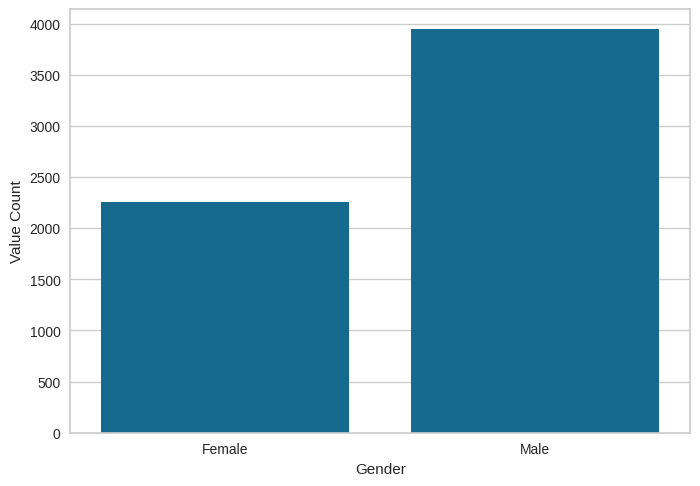

In [10]:
X= df['gender'].value_counts()


sns.countplot(x='gender',data=df)
plt.xlabel('Gender')
plt.ylabel('Value Count')
print(X)

race
White       1456
Asian       1147
Black        916
Hispanic     596
Other        237
Name: count, dtype: int64


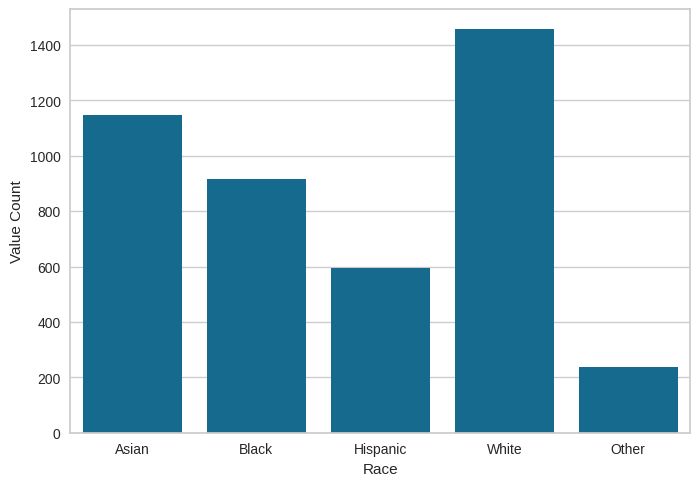

In [11]:
sns.countplot(x='race',data=df)
plt.xlabel('Race')
plt.ylabel('Value Count')
print(df['race'].value_counts())

major
Humanities    2481
STEM          1875
Business      1838
Name: count, dtype: int64


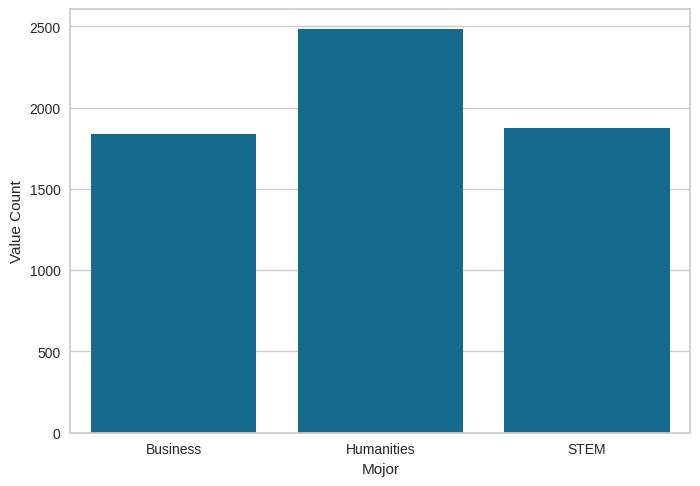

In [12]:
sns.countplot(x='major',data=df)
plt.xlabel('Mojor')
plt.ylabel('Value Count')
print(df['major'].value_counts())

In [13]:
df[df['race'].isnull()==True]

,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
2,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
7,Male,True,3.02,Business,NaN,630.0,6.0,Financial Services,NaN
11,Male,True,2.85,Humanities,NaN,580.0,4.0,PE/VC,NaN
15,Female,True,3.05,Humanities,NaN,710.0,4.0,Consulting,Admit
19,Male,True,3.09,Business,NaN,670.0,8.0,Consulting,NaN
...,...,...,...,...,...,...,...,...,...
6167,Male,True,3.24,Business,NaN,570.0,4.0,Consulting,NaN
6176,Female,True,3.29,Business,NaN,640.0,5.0,Technology,NaN
6186,Male,True,3.23,Humanities,NaN,610.0,7.0,Financial Services,NaN
6191,Female,True,3.22,Business,NaN,680.0,5.0,Health Care,Admit


work_industry
Consulting               1619
PE/VC                     907
Technology                716
Nonprofit/Gov             651
Investment Banking        580
Financial Services        451
Other                     421
Health Care               334
Investment Management     166
CPG                       114
Name: count, dtype: int64


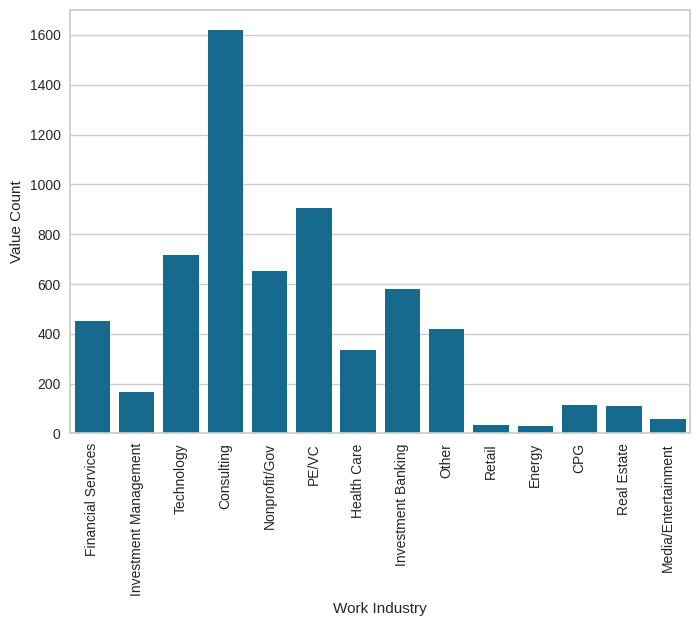

In [14]:
sns.countplot(x='work_industry',data=df)
plt.xlabel('Work Industry')
plt.ylabel('Value Count')
plt.xticks(rotation=90)
print(df['work_industry'].value_counts().head(10))

admission
Admit       900
Waitlist    100
Name: count, dtype: int64


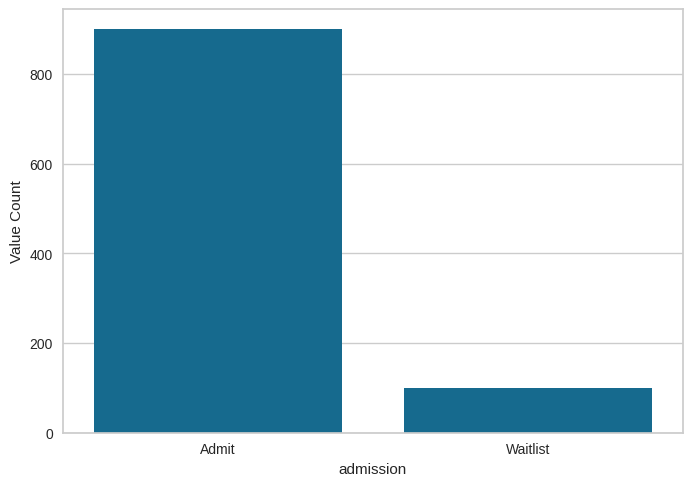

In [15]:
sns.countplot(x='admission',data=df)
plt.xlabel('admission')
plt.ylabel('Value Count')
print(df['admission'].value_counts())

<Axes: >

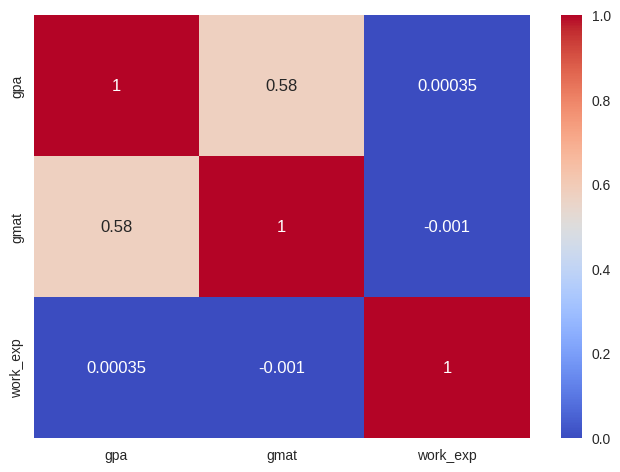

In [16]:
data = df.drop('admission',axis=1)
numeric_data = data.select_dtypes(include=['float64', 'int64'])

corr = numeric_data.corr()

sns.heatmap(corr,annot=True,cmap='coolwarm')

**Numerical Embedding of Categorical Data**

In [17]:
df['gender'] = df['gender'].map({'Male':1,'Female':0})

In [18]:
df['admission']  = df['admission'].map({'Admit':1,'Waitlist':0}).fillna(0)

In [19]:
df.head()

,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,0,False,3.30,Business,Asian,620.0,3.0,Financial Services,1.0
1,1,False,3.28,Humanities,Black,680.0,5.0,Investment Management,0.0
2,0,True,3.30,Business,NaN,710.0,5.0,Technology,1.0
3,1,False,3.47,STEM,Black,690.0,6.0,Technology,0.0
4,1,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,0.0


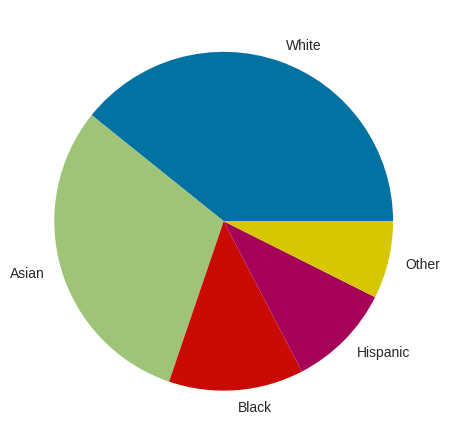

In [20]:
race = df[df['admission'] == 1]['race']

plt.pie(race.value_counts(),labels=race.value_counts().index)
plt.show()

In [21]:
X = df.drop('admission',axis=1)
X = pd.get_dummies(X,drop_first=True)
Y = df['admission']

In [22]:
X.head()

,gender,international,gpa,gmat,work_exp,major_Humanities,major_STEM,race_Black,race_Hispanic,race_Other,...,work_industry_Health Care,work_industry_Investment Banking,work_industry_Investment Management,work_industry_Media/Entertainment,work_industry_Nonprofit/Gov,work_industry_Other,work_industry_PE/VC,work_industry_Real Estate,work_industry_Retail,work_industry_Technology
0,0,False,3.30,620.0,3.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,False,3.28,680.0,5.0,True,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
2,0,True,3.30,710.0,5.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,1,False,3.47,690.0,6.0,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,True
4,1,False,3.35,590.0,5.0,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [25]:
y_train.head()

,admission
6189,0.0
711,1.0
3954,1.0
1020,1.0
5726,0.0


In [29]:
SVC_model = SVC()

SVC_model.fit(X_train,y_train)
SVC_predict = SVC_model.predict(X_test)

accuracy = accuracy_score(y_test,SVC_predict)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 84.18%
